In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datasets import *
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from random import randint
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

Using TensorFlow backend.


In [2]:
from models.gap_mask import gap_mask

model = gap_mask(imsize=256)

 [!] Conv Spec:
 [!] 256 => 128: [64, 128]
 [!] 128 => 64: [256, 256, 256, 256]
 [!] 64 => 32: [256, 256, 256, 256]
 [!] 32 => 16: [512, 512, 512, 512]
 [!] 16 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [1024, 1024, 2048, 2048]


In [3]:
print(model.count_params())
model.compile()

149.7 million


In [4]:
dset = Tissue()

 [*] tissue_sick: 2118 unique cases (2118 total)
 [*] tissue_healthy: 2951 unique cases (278564 total)
 [*] tissue_sick: 1606 / 512
 [*] tissue_healthy: 229652 / 48912


In [5]:
samplegen = dset.gen(bsize=8, regionsize=8, labels=['regions', 'lbls', 'refs'])

In [6]:
imgs, (regions, lbls), refs = next(samplegen)

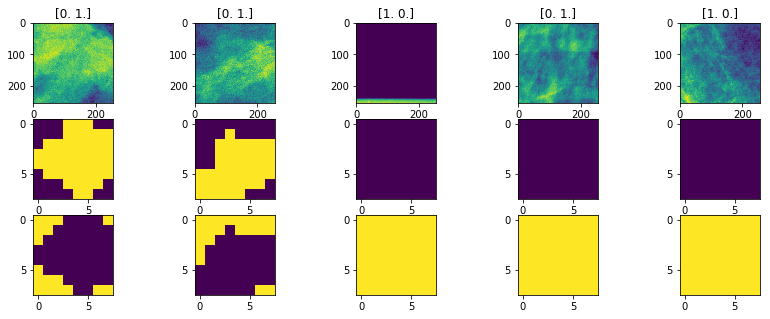

In [7]:
plt.figure(figsize=(14, 5))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    plt.gca().set_title(lbls[ii])
    plt.imshow(imgs[ii, :, :, 0])
    plt.subplot(3, 5, 5+ii+1)
    plt.imshow(regions[ii, :, :, 1])
    plt.subplot(3, 5, 5*2+ii+1)
    plt.imshow(regions[ii, :, :, 0], vmin=0, vmax=1)
plt.show()
plt.close()

In [10]:
counter = 0
class Checkpoint(keras.callbacks.Callback):
    def __init__(self, evalset):
        self.evalset = evalset
        _, (_, _), refs = self.evalset
        print('Preview set:')
        for ii in range(7):
            print('  %s' % refs[ii].split('/')[-1])
        
    def on_batch_begin(self, batch, logs={}):
        global counter
        if counter % 200 == 0:
            if counter != 0:
                model.save() # save after first interval
            
            imgs, (regions, lbls), refs = self.evalset
            rpnout, yout = model.model.predict(imgs)

            imgs, (regions, lbls), refs = self.evalset

            plt.figure(figsize=(14, 4))
            for ii in range(7): # preview 7 images
                plt.subplot(3, 7, ii+1)
                plt.axis('off')
                plt.gca().set_title(lbls[ii])
                plt.imshow(imgs[ii, :, :, 0])

                plt.subplot(3, 7, 7+ii+1)
                plt.axis('off')
                plt.imshow(regions[ii, :, :, 1], vmin=0, vmax=1)
                
                plt.subplot(3, 7, 14+ii+1)
                plt.axis('off')
                plt.gca().set_title('%.2f' % yout[ii, 1])
                plt.imshow(rpnout[ii, :, :, 1], vmin=0, vmax=1)
            plt.show()
            plt.close()
        counter += 1
        return

Preview set:
  00026_LEFT_MLO.npy
  00023_RIGHT_CC.npy
  00303_LEFT_CC.npy
  00862_LEFT_MLO.npy
  01805_LEFT_CC.npy
  00562_LEFT_MLO.npy
  01675_RIGHT_CC.npy
Epoch 1/12


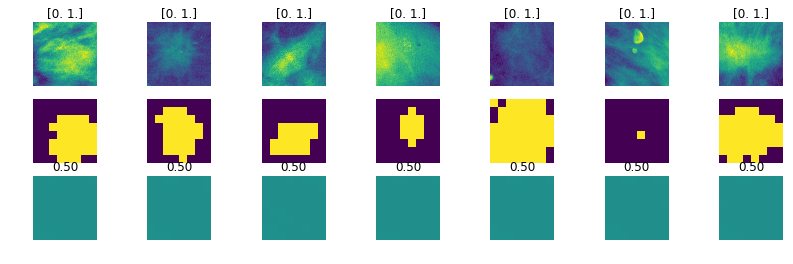

200/285 [====================>.........] - ETA: 1:33 - loss: 0.5637 - rpn_loss: -0.0350 - yhat_loss: 0.5986 - rpn_outer_penalty: 0.0834 - yhat_acc: 0.6980

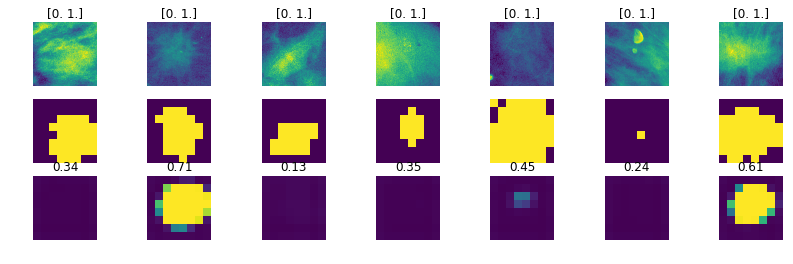

285/285 [==============================] - 315s 1s/step - loss: 0.5307 - rpn_loss: -0.0426 - yhat_loss: 0.5733 - rpn_outer_penalty: 0.0767 - yhat_acc: 0.7129 - val_loss: 0.7817 - val_rpn_loss: 0.0784 - val_yhat_loss: 0.7033 - val_rpn_outer_penalty: 0.2780 - val_yhat_acc: 0.7143
Epoch 2/12
115/285 [===========>..................] - ETA: 3:01 - loss: 0.4183 - rpn_loss: -0.0723 - yhat_loss: 0.4906 - rpn_outer_penalty: 0.0596 - yhat_acc: 0.7702

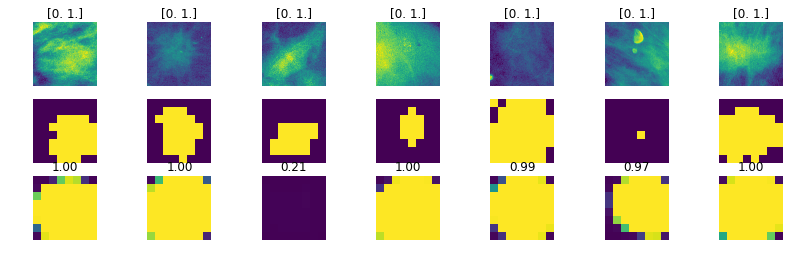

285/285 [==============================] - 304s 1s/step - loss: 0.4022 - rpn_loss: -0.0768 - yhat_loss: 0.4790 - rpn_outer_penalty: 0.0580 - yhat_acc: 0.7772 - val_loss: 0.2938 - val_rpn_loss: -0.0405 - val_yhat_loss: 0.3343 - val_rpn_outer_penalty: 0.0893 - val_yhat_acc: 0.8571
Epoch 3/12
 30/285 [==>...........................] - ETA: 4:27 - loss: 0.3668 - rpn_loss: -0.0793 - yhat_loss: 0.4461 - rpn_outer_penalty: 0.0603 - yhat_acc: 0.7905

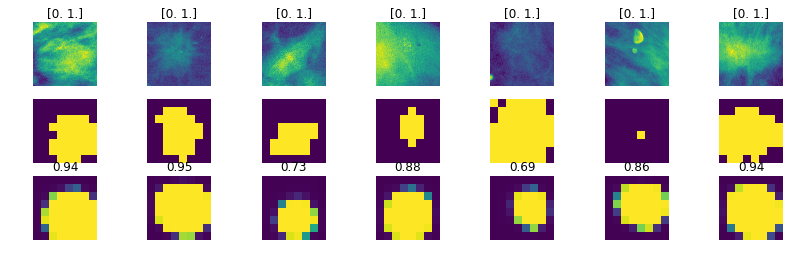

230/285 [=======================>......] - ETA: 59s - loss: 0.3466 - rpn_loss: -0.0839 - yhat_loss: 0.4305 - rpn_outer_penalty: 0.0576 - yhat_acc: 0.8067 

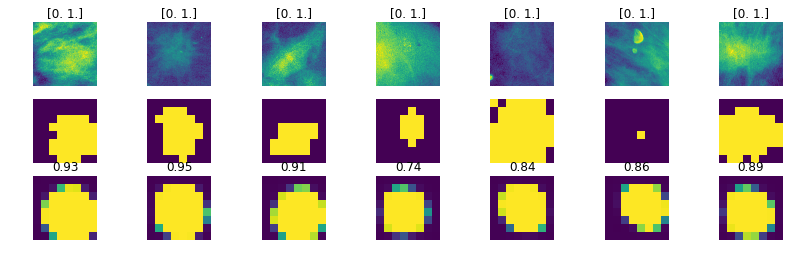

285/285 [==============================] - 323s 1s/step - loss: 0.3409 - rpn_loss: -0.0839 - yhat_loss: 0.4248 - rpn_outer_penalty: 0.0577 - yhat_acc: 0.8107 - val_loss: 0.3031 - val_rpn_loss: -0.0584 - val_yhat_loss: 0.3615 - val_rpn_outer_penalty: 0.1339 - val_yhat_acc: 0.8214
Epoch 4/12
145/285 [==============>...............] - ETA: 4:43 - loss: 0.3151 - rpn_loss: -0.0885 - yhat_loss: 0.4036 - rpn_outer_penalty: 0.0559 - yhat_acc: 0.8197

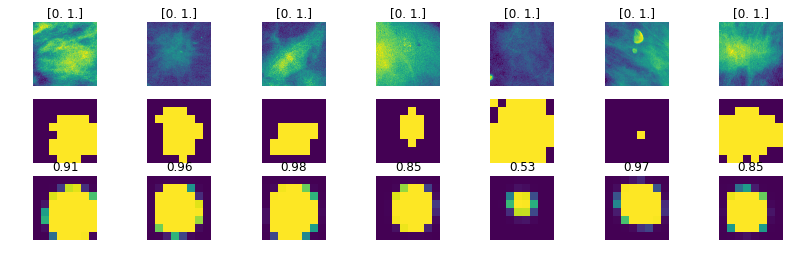

285/285 [==============================] - 573s 2s/step - loss: 0.3093 - rpn_loss: -0.0905 - yhat_loss: 0.3997 - rpn_outer_penalty: 0.0553 - yhat_acc: 0.8272 - val_loss: 0.5184 - val_rpn_loss: -0.0131 - val_yhat_loss: 0.5315 - val_rpn_outer_penalty: 0.1199 - val_yhat_acc: 0.7143
Epoch 5/12
 45/285 [===>..........................] - ETA: 7:44 - loss: 0.2821 - rpn_loss: -0.0960 - yhat_loss: 0.3781 - rpn_outer_penalty: 0.0576 - yhat_acc: 0.8357

In [ ]:
bsize = 28

previewset = next(dset.gen(
    bsize=bsize, mode='test', regionsize=8, labels=['regions', 'lbls', 'refs'], sickonly=True))
datagen = dset.gen(bsize=bsize, regionsize=8, labels=['regions', 'lbls'])
evalgen = dset.gen(bsize=bsize, mode='test', regionsize=8, labels=['regions', 'lbls'])

model.model.fit_generator(
    datagen,
    epochs=12,
    verbose=1,
    steps_per_epoch=dset.train_size // bsize * 5, # do x10 to experience many augmentations
    
    validation_data=evalgen,
    validation_steps=dset.test_size // bsize // 10, # just do 10th of val data
    
    callbacks=[Checkpoint(previewset)]
)


## preds, yguess = model.model.predict(imgs)

In [ ]:
plt.figure(figsize=(14, 7))
for ii in range(5):
    plt.subplot(4, 5, ii+1)
    plt.gca().set_title(lbls[ii])
    plt.imshow(imgs[ii, :, :, 0])
    plt.subplot(4, 5, 5+ii+1)
    plt.gca().set_title(np.argmax(yguess[ii]))
    plt.imshow(preds[ii, :, :, 1], vmin=0, vmax=1)
    plt.subplot(4, 5, 5*2+ii+1)
    plt.imshow(preds[ii, :, :, 0], vmin=0, vmax=1)
    plt.subplot(4, 5, 5*3+ii+1)
    plt.imshow(regions[ii, :, :, 1], vmin=0, vmax=1)
plt.show()
plt.close()
for ii in range(5):
    print(refs[ii])

In [ ]:
from utils import *

plot_raw('00468_LEFT_CC')

In [ ]:
plt.figure(figsize=(14, 7))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    plt.axis('off')
    plt.gca().set_title(lbls[ii])
    plt.imshow(imgs[ii, :, :, 0])
    
    plt.subplot(3, 5, 5*1+ii+1)
    plt.axis('off')
    plt.gca().set_title('Mask Predicted')
    plt.imshow(imgs[ii, :, :, 0])
    large = cv2.resize(preds[ii, :, :, 1], (0,0), fx=32, fy=32)
    plt.imshow(large, vmin=0, vmax=1, alpha=0.5)
    
    plt.subplot(3, 5, 5*2+ii+1)
    plt.axis('off')
    plt.gca().set_title('Mask Given')
    plt.imshow(imgs[ii, :, :, 0])
    large = cv2.resize(regions[ii, :, :, 1], (0,0), fx=32, fy=32)
    plt.imshow(large, vmin=0, vmax=1, alpha=0.5)
plt.show()
plt.close()
for ii in range(5):
    print(refs[ii])

In [ ]:
_ = plot_raw('00468_LEFT_MLO')